In [1]:
!pip install transformers datasets accelerate torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: 

In [2]:
def print_header(text, width=55, char="─"):
    print(f"\n{char * width}")
    print(f"{text:^{width}}")
    print(f"{char * width}\n")

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-agile-community-rules/sample_submission.csv
/kaggle/input/jigsaw-agile-community-rules/train.csv
/kaggle/input/jigsaw-agile-community-rules/test.csv


In [4]:
import re
import json
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, TrainingArguments, Trainer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from accelerate import PartialState
from transformers import EarlyStoppingCallback

2025-09-29 12:09:05.697384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759147745.955563      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759147746.022316      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
distributed_state = PartialState()

In [6]:
def url_to_semantics(text):
    """
    Extract meaningful keywords from URLs in text.
    
    Args:
        text (str): Input text containing URLs
        
    Returns:
        str: Formatted string with URL keywords or empty string if no URLs found
    """
    if not isinstance(text, str):
        return ""
    
    # Regular expression to match URLs
    url_pattern = re.compile(
        r'https?://'  # http:// or https://
        r'(?:www\.)?'  # optional www.
        r'([^/?]+)'  # domain (group 1)
        r'(?:[^/]*)'  # optional TLD and port
        r'(/[^/?]*)'  # path (group 2)
    )
    
    urls = url_pattern.findall(text)
    
    if not urls:
        return ""
    
    keywords = []
    
    for domain, path in urls:
        # Clean domain: remove TLD and common prefixes
        domain = domain.split('.')[0]  # Take first part before dot
        if domain and domain not in ['www', 'http', 'https']:
            keywords.append(f"domain:{domain}")
        
        # Clean path: remove leading slash and split
        if path and len(path) > 1:  # Ensure path is not just "/"
            path_parts = path.strip('/').split('/')
            for part in path_parts:
                # Skip empty parts, numbers, or very short parts
                if part and not part.isdigit() and len(part) > 2:
                    # Skip common file extensions
                    if part.lower() not in ['jpg', 'jpeg', 'png', 'gif', 'html', 'php', 'asp', 'aspx']:
                        keywords.append(f"path:{part}")
                        break  # Only take the first meaningful path part
    
    # Remove duplicates while preserving order
    seen = set()
    unique_keywords = []
    for kw in keywords:
        if kw not in seen:
            seen.add(kw)
            unique_keywords.append(kw)
    
    if unique_keywords:
        return "URL Keywords: " + " ".join(unique_keywords)
    else:
        return ""

In [7]:
# Load data
train_df = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/train.csv')

# Apply URL keyword extraction
train_df["body_with_url"] = train_df["body"].apply(lambda x: x + " " + url_to_semantics(x))

# Create combined text with rule and body_with_url
train_df['combined_text'] = train_df["rule"] + "[SEP]" + train_df["body_with_url"]

# Prepare data for k-fold
texts = train_df['combined_text'].tolist()
labels = train_df['rule_violation'].tolist()

In [8]:
class RedditDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=1024):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [9]:
# Initialize tokenizer
model_name = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create configuration
config = AutoConfig.from_pretrained(model_name)
config.hidden_dropout_prob = 0.3
config.attention_probs_dropout_prob = 0.3
config.num_labels = 2
config.problem_type = "single_label_classification"

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [10]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()
    auc = roc_auc_score(labels, probs)
    return {"auc": auc}

In [11]:
# Fixed CustomTrainer
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.training_losses = []
        self.validation_losses = []
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        labels = labels.long()
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, 2), labels.view(-1))
        
        self.training_losses.append(loss.item())
        
        return (loss, outputs) if return_outputs else loss
    
    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        eval_output = super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)
        
        if "eval_loss" in eval_output:
            self.validation_losses.append(eval_output["eval_loss"])
        
        return eval_output

In [12]:
def analyze_kfold_performance(all_fold_results, train_texts_fold, training_args):
    """
    Analyze model performance across k-fold cross-validation to detect underfitting/overfitting
    """
    print("\n" + "="*60)
    print("K-FOLD CROSS-VALIDATION ANALYSIS")
    print("="*60)
    
    # Extract AUC scores
    auc_scores = [result['auc'] for result in all_fold_results]
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    
    print(f"Mean AUC: {mean_auc:.4f} ± {std_auc:.4f}")
    print(f"Individual Fold AUCs: {[f'{auc:.4f}' for auc in auc_scores]}")
    
    # Analyze loss curves
    max_epochs = max(len(result['val_loss']) for result in all_fold_results)
    avg_train_loss = np.zeros(max_epochs)
    avg_val_loss = np.zeros(max_epochs)
    epoch_counts = np.zeros(max_epochs)
    
    # Calculate average losses per epoch
    for result in all_fold_results:
        train_losses = result['train_loss']
        val_losses = result['val_loss']
        
        # Group training losses by epoch
        # Account for gradient accumulation
        steps_per_epoch = len(train_texts_fold) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps)
        train_losses_per_epoch = [train_losses[i:i+steps_per_epoch] for i in range(0, len(train_losses), steps_per_epoch)]
        
        for epoch, (train_epoch_losses, val_loss) in enumerate(zip(train_losses_per_epoch, val_losses)):
            if epoch < max_epochs:
                avg_train_loss[epoch] += np.mean(train_epoch_losses)
                avg_val_loss[epoch] += val_loss
                epoch_counts[epoch] += 1
    
    # Calculate averages
    for epoch in range(max_epochs):
        if epoch_counts[epoch] > 0:
            avg_train_loss[epoch] /= epoch_counts[epoch]
            avg_val_loss[epoch] /= epoch_counts[epoch]
    
    # Find best epoch
    best_epoch = np.argmin(avg_val_loss)
    best_train_loss = avg_train_loss[best_epoch]
    best_val_loss = avg_val_loss[best_epoch]
    
    print(f"\nBest Performance at Epoch {best_epoch+1}:")
    print(f"Training Loss: {best_train_loss:.4f}")
    print(f"Validation Loss: {best_val_loss:.4f}")
    print(f"Loss Gap (Val - Train): {best_val_loss - best_train_loss:.4f}")
    
    # Analyze underfitting/overfitting
    print("\n" + "-"*60)
    print("MODEL STATUS ANALYSIS")
    print("-"*60)
    
    # Check for underfitting
    if best_train_loss > 0.5 and best_val_loss > 0.5:
        print("Status: UNDERFITTING")
        print("Reasons: Both training and validation losses are high")
        print("Recommendations:")
        print("- Increase model capacity (use larger model)")
        print("- Train for more epochs")
        print("- Reduce regularization")
        print("- Increase learning rate")
    
    # Check for overfitting
    elif (best_val_loss - best_train_loss) > 0.1:
        print("Status: OVERFITTING")
        print("Reasons: Validation loss is significantly higher than training loss")
        print("Recommendations:")
        print("- Add more dropout")
        print("- Increase weight decay")
        print("- Use early stopping with lower patience")
        print("- Add data augmentation")
        print("- Reduce model complexity")
    
    # Check for good fit
    elif best_train_loss < 0.4 and best_val_loss < 0.4 and abs(best_val_loss - best_train_loss) < 0.05:
        print("Status: GOOD FIT")
        print("Reasons: Both losses are low and close to each other")
        print("Recommendations:")
        print("- Continue monitoring for overfitting")
        print("- Consider fine-tuning hyperparameters")
        print("- Try ensemble methods for further improvement")
    
    # Check for under-optimized
    else:
        print("Status: UNDER-OPTIMIZED")
        print("Reasons: Model has potential but needs more optimization")
        print("Recommendations:")
        print("- Train for more epochs")
        print("- Adjust learning rate")
        print("- Try different optimizers")
        print("- Tune hyperparameters more carefully")
    
    # Analyze consistency across folds
    print("\n" + "-"*60)
    print("FOLD CONSISTENCY ANALYSIS")
    print("-"*60)
    
    if std_auc < 0.02:
        print("Consistency: VERY HIGH")
        print("The model performs consistently across all folds")
    elif std_auc < 0.05:
        print("Consistency: HIGH")
        print("The model performs quite consistently across folds")
    elif std_auc < 0.1:
        print("Consistency: MODERATE")
        print("There's some variation in performance across folds")
    else:
        print("Consistency: LOW")
        print("Performance varies significantly across folds")
        print("Recommendations:")
        print("- Check for data distribution issues")
        print("- Consider stratified sampling")
        print("- Increase training data")
    
    # Plot loss curves
    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")
    
    epochs = range(1, max_epochs + 1)
    sns.lineplot(x=epochs, y=avg_train_loss, label='Average Training Loss', marker='o', linewidth=2)
    sns.lineplot(x=epochs, y=avg_val_loss, label='Average Validation Loss', marker='s', linewidth=2)
    
    # Mark best epoch
    plt.axvline(x=best_epoch+1, color='red', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch+1})')
    
    plt.title('Average Training vs Validation Loss Across Folds', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.xticks(epochs)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('./loss_analysis.png')
    plt.show()
    
    # Plot individual fold performances
    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")
    
    fold_nums = [result['fold'] for result in all_fold_results]
    fold_aucs = [result['auc'] for result in all_fold_results]
    
    sns.barplot(x=fold_nums, y=fold_aucs, palette='viridis')
    plt.axhline(y=mean_auc, color='red', linestyle='--', label=f'Mean AUC ({mean_auc:.4f})')
    
    plt.title('AUC Scores Across Folds', fontsize=16)
    plt.xlabel('Fold', fontsize=14)
    plt.ylabel('AUC', fontsize=14)
    plt.ylim(0.5, 1.0)  # AUC range
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('./fold_performance.png')
    plt.show()
    
    return {
        'mean_auc': mean_auc,
        'std_auc': std_auc,
        'best_epoch': best_epoch,
        'best_train_loss': best_train_loss,
        'best_val_loss': best_val_loss,
        'loss_gap': best_val_loss - best_train_loss
    }

In [13]:
# Set up k-fold cross-validation
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Track best model across folds
best_auc = 0
best_fold = None
best_model_path = "./results/best_model"  # Final best model
best_fold_model_dir = None  # For backup of best fold's full dir

# Store results for analysis
all_fold_results = []

# Create output directories
os.makedirs("./results", exist_ok=True)

print_header("Starting K-Fold Cross-Validation")


───────────────────────────────────────────────────────
           Starting K-Fold Cross-Validation            
───────────────────────────────────────────────────────



In [17]:
# --- K-Fold Loop ---
for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print_header(f"Training Fold {fold+1}/{n_splits}")

    # Split data
    train_texts_fold = [texts[i] for i in train_idx]
    train_labels_fold = [labels[i] for i in train_idx]
    val_texts_fold = [texts[i] for i in val_idx]
    val_labels_fold = [labels[i] for i in val_idx]

    # Create datasets
    train_dataset = RedditDataset(train_texts_fold, train_labels_fold, tokenizer)
    val_dataset = RedditDataset(val_texts_fold, val_labels_fold, tokenizer)

    # Initialize model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

    # Output dir per fold
    fold_output_dir = f"./results/fold_{fold}"
    os.makedirs(fold_output_dir, exist_ok=True)

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"{fold_output_dir}/checkpoints",
        num_train_epochs=10,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        gradient_accumulation_steps=2,
        learning_rate=1e-5,
        warmup_ratio=0.1,
        weight_decay=0.1,
        max_grad_norm=1.0,
        lr_scheduler_type="cosine",
        logging_dir=f"{fold_output_dir}/logs",
        logging_steps=100,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model="auc", 
        greater_is_better=True,
        report_to="none",
        fp16=True,
        bf16=False,
        local_rank=-1,
        ddp_find_unused_parameters=False,
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # More robust
    )

    # --- Training ---
    try:
        trainer.train()
    except Exception as e:
        print(f"❌ Training failed on fold {fold+1}: {e}")
        del model, trainer
        torch.cuda.empty_cache()
        continue

    # --- Evaluation ---
    eval_result = trainer.evaluate()
    fold_auc = eval_result["eval_auc"]
    print(f"Fold {fold+1} AUC: {fold_auc:.4f}")

    # Extract losses
    train_losses = [log["loss"] for log in trainer.state.log_history if "loss" in log and "eval_loss" not in log]
    val_losses = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]

    # Save fold results
    fold_result = {
        'fold': fold + 1,
        'auc': fold_auc,
        'train_loss': train_losses,
        'val_loss': val_losses,
        'epochs': len(val_losses),
        'early_stopped': len(val_losses) < training_args.num_train_epochs
    }
    all_fold_results.append(fold_result)

    # Save fold summary (even if not best)
    with open(f"{fold_output_dir}/fold_summary.json", "w") as f:
        json.dump(fold_result, f, indent=2)

    # Save to central results file
    with open("./results/fold_results.json", "w") as f:
        json.dump(all_fold_results, f, indent=2)

    # --- Save Best Model Across Folds ---
    if fold_auc > best_auc:
        # Backup previous best if exists
        if os.path.exists(best_model_path):
            backup_path = f"{best_model_path}_backup_fold{best_fold}"
            if os.path.exists(backup_path):
                shutil.rmtree(backup_path)
            shutil.move(best_model_path, backup_path)
            print(f"📦 Previous best model backed up to {backup_path}")

        # Save current best
        if os.path.exists(best_model_path):
            shutil.rmtree(best_model_path)
        trainer.save_model(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        best_auc = fold_auc
        best_fold = fold
        best_fold_model_dir = fold_output_dir  # Save full dir for reference
        print(f"✅ New best model saved! Fold {fold+1} with AUC: {fold_auc:.4f}")

    # --- Cleanup: Delete checkpoints, keep logs and summary ---
    checkpoint_dir = f"{fold_output_dir}/checkpoints"
    if os.path.exists(checkpoint_dir):
        shutil.rmtree(checkpoint_dir)  # Delete checkpoints only
        print(f"🧹 Checkpoints cleaned up for fold {fold+1}")

    # --- Memory cleanup ---
    del model, trainer
    torch.cuda.empty_cache()
    print(f"🧠 Memory cleaned for fold {fold+1}")

# --- End of Loop ---
print_header("K-Fold CV Completed!")

# --- Final Summary ---
print(f"\n🏆 Best Fold: {best_fold + 1} | AUC: {best_auc:.4f}")
print(f"📊 All Fold AUCs: {[r['auc'] for r in all_fold_results]}")
print(f"📈 Mean AUC: {np.mean([r['auc'] for r in all_fold_results]):.4f} ± {np.std([r['auc'] for r in all_fold_results]):.4f}")

# --- Final Cleanup: Keep only best model and results ---
print("✅ Pipeline complete. Best model at:", best_model_path)
print("📁 Full results and logs in ./results/")


───────────────────────────────────────────────────────
                   Training Fold 1/5                   
───────────────────────────────────────────────────────



model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/2308874257.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
W0929 12:11:43.522000 36 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Auc
1,No log,0.582240,0.780595
2,1.227500,0.488580,0.842561
3,1.227500,0.495414,0.843896
4,0.760800,0.669368,0.855886
5,0.760800,0.608531,0.853240
6,0.387300,0.701878,0.850231
7,0.387300,0.815086,0.840546


Fold 1 AUC: 0.8559
✅ New best model saved! Fold 1 with AUC: 0.8559
🧹 Checkpoints cleaned up for fold 1


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🧠 Memory cleaned for fold 1

───────────────────────────────────────────────────────
                   Training Fold 2/5                   
───────────────────────────────────────────────────────



/tmp/ipykernel_36/2308874257.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Auc
1,No log,0.630670,0.729502
2,1.250100,0.630104,0.777779
3,1.250100,0.599477,0.780073
4,0.820600,0.591994,0.801238
5,0.820600,0.604080,0.798398
6,0.492100,0.724522,0.805570
7,0.492100,0.811743,0.801044
8,0.222100,0.826110,0.802779
9,0.222100,0.897034,0.798034


Fold 2 AUC: 0.8056
🧹 Checkpoints cleaned up for fold 2


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🧠 Memory cleaned for fold 2

───────────────────────────────────────────────────────
                   Training Fold 3/5                   
───────────────────────────────────────────────────────



/tmp/ipykernel_36/2308874257.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Auc
1,No log,0.608571,0.723968
2,1.219900,0.565762,0.831323
3,1.219900,0.544282,0.816068
4,0.820600,0.514144,0.839551
5,0.820600,0.630769,0.842985
6,0.432200,0.577910,0.855243
7,0.432200,0.639143,0.857767
8,0.196600,0.708104,0.860316
9,0.196600,0.715297,0.861541
10,0.091400,0.719036,0.862888


Fold 3 AUC: 0.8629
📦 Previous best model backed up to ./results/best_model_backup_fold0
✅ New best model saved! Fold 3 with AUC: 0.8629
🧹 Checkpoints cleaned up for fold 3


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🧠 Memory cleaned for fold 3

───────────────────────────────────────────────────────
                   Training Fold 4/5                   
───────────────────────────────────────────────────────



/tmp/ipykernel_36/2308874257.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Auc
1,No log,0.626251,0.718921
2,1.273400,0.536326,0.809579
3,1.273400,0.506839,0.825262
4,0.867200,0.655186,0.797890
5,0.867200,0.580228,0.838698
6,0.521900,0.600997,0.840822
7,0.521900,0.696548,0.832010
8,0.268200,0.730927,0.838589
9,0.268200,0.743591,0.838128


Fold 4 AUC: 0.8408
🧹 Checkpoints cleaned up for fold 4


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🧠 Memory cleaned for fold 4

───────────────────────────────────────────────────────
                   Training Fold 5/5                   
───────────────────────────────────────────────────────



/tmp/ipykernel_36/2308874257.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Auc
1,No log,0.644555,0.677258
2,1.228800,0.609297,0.773967
3,1.228800,0.559057,0.808667
4,0.825500,0.590991,0.804008
5,0.825500,0.559991,0.832841
6,0.487100,0.619922,0.835744
7,0.487100,0.703965,0.827536
8,0.215200,0.724232,0.833695
9,0.215200,0.733250,0.836257
10,0.116500,0.729431,0.836159


Fold 5 AUC: 0.8363
🧹 Checkpoints cleaned up for fold 5
🧠 Memory cleaned for fold 5

───────────────────────────────────────────────────────
                 K-Fold CV Completed!                  
───────────────────────────────────────────────────────


🏆 Best Fold: 3 | AUC: 0.8629
📊 All Fold AUCs: [0.8558859223300971, 0.8055703883495146, 0.8628883495145632, 0.8408224698371083, 0.8362565253451726]
📈 Mean AUC: 0.8403 ± 0.0199
✅ Pipeline complete. Best model at: ./results/best_model
📁 Full results and logs in ./results/



K-Fold Cross-Validation Complete
Best Fold: 3
Best AUC: 0.8629
Best model saved to: ./results/best_model

K-FOLD CROSS-VALIDATION ANALYSIS
Mean AUC: 0.8403 ± 0.0199
Individual Fold AUCs: ['0.8559', '0.8056', '0.8629', '0.8408', '0.8363']

Best Performance at Epoch 2:
Training Loss: 0.0000
Validation Loss: 0.0000
Loss Gap (Val - Train): 0.0000

------------------------------------------------------------
MODEL STATUS ANALYSIS
------------------------------------------------------------
Status: GOOD FIT
Reasons: Both losses are low and close to each other
Recommendations:
- Continue monitoring for overfitting
- Consider fine-tuning hyperparameters
- Try ensemble methods for further improvement

------------------------------------------------------------
FOLD CONSISTENCY ANALYSIS
------------------------------------------------------------
Consistency: VERY HIGH
The model performs consistently across all folds


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

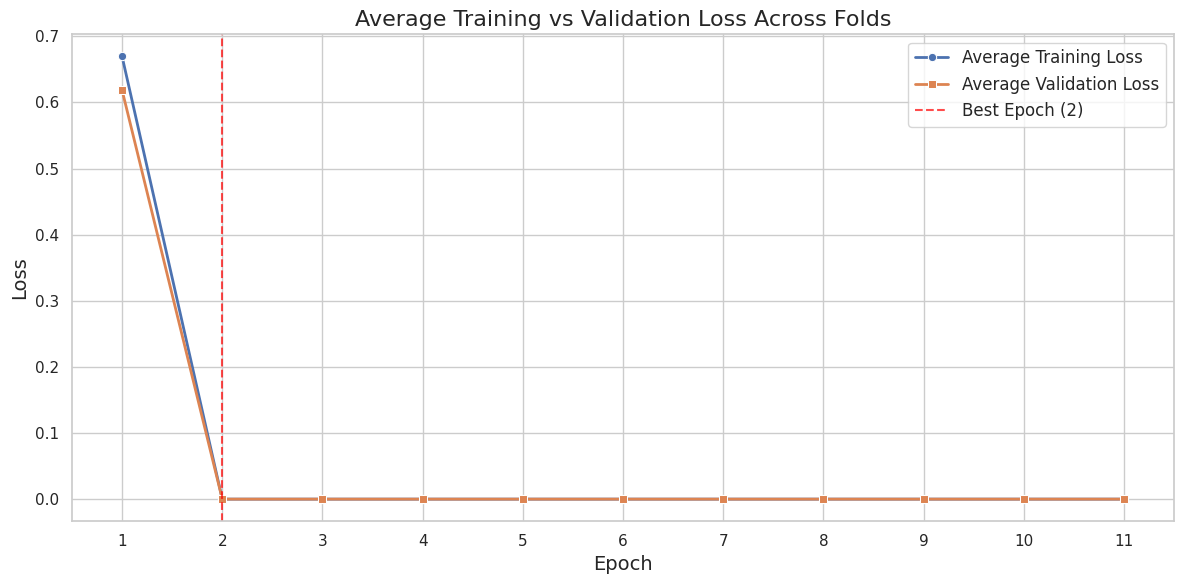

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


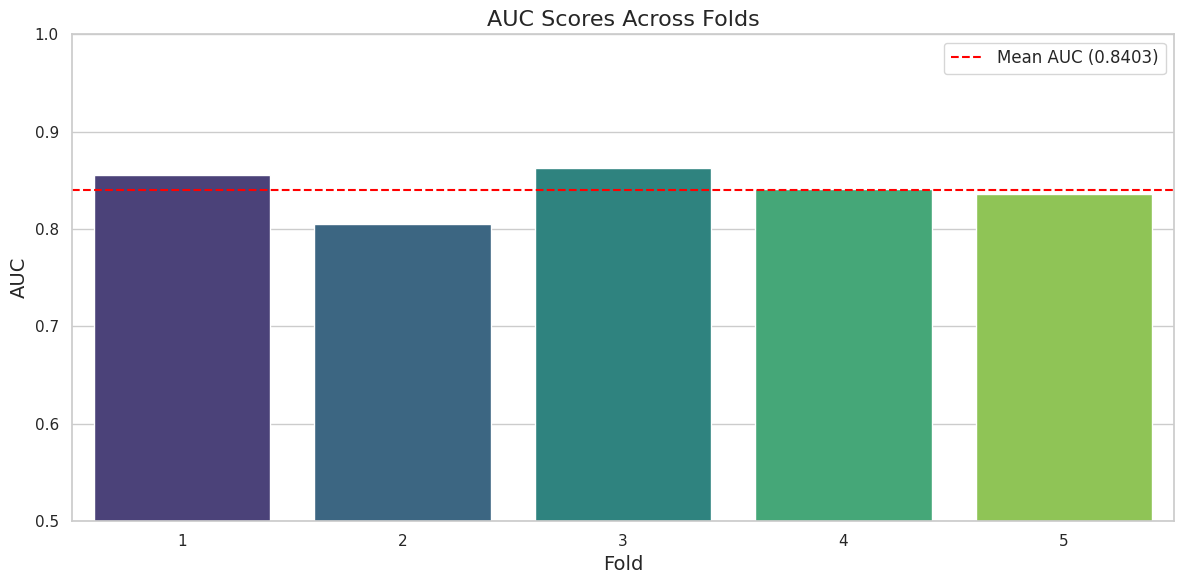


FINAL SUMMARY
Best Model: Fold 3
Best AUC: 0.8629
Mean AUC across folds: 0.8403
Best Epoch: 2
Loss Gap: 0.0000


In [18]:
print(f"\n{'='*50}")
print(f"K-Fold Cross-Validation Complete")
print(f"{'='*50}")
print(f"Best Fold: {best_fold+1}")
print(f"Best AUC: {best_auc:.4f}")
print(f"Best model saved to: {best_model_path}")

# Analyze performance
analysis_results = analyze_kfold_performance(all_fold_results, train_texts_fold, training_args)

# Print summary
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"Best Model: Fold {best_fold+1}")
print(f"Best AUC: {best_auc:.4f}")
print(f"Mean AUC across folds: {analysis_results['mean_auc']:.4f}")
print(f"Best Epoch: {analysis_results['best_epoch']+1}")
print(f"Loss Gap: {analysis_results['loss_gap']:.4f}")

# Save analysis results
with open('./analysis_results.txt', 'w') as f:
    f.write(f"Best Fold: {best_fold+1}\n")
    f.write(f"Best AUC: {best_auc:.4f}\n")
    f.write(f"Mean AUC: {analysis_results['mean_auc']:.4f}\n")
    f.write(f"Std AUC: {analysis_results['std_auc']:.4f}\n")
    f.write(f"Best Epoch: {analysis_results['best_epoch']+1}\n")
    f.write(f"Best Training Loss: {analysis_results['best_train_loss']:.4f}\n")
    f.write(f"Best Validation Loss: {analysis_results['best_val_loss']:.4f}\n")
    f.write(f"Loss Gap: {analysis_results['loss_gap']:.4f}\n")